In [1]:
!wget https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttest.bio
!wget https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttrain.bio

--2024-06-09 01:06:56--  https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttest.bio
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155722 (152K)
Saving to: ‘restauranttest.bio’

restauranttest.bio  100%[===================>] 152.07K   146KB/s    in 1.0s    

2024-06-09 01:06:59 (146 KB/s) - ‘restauranttest.bio’ saved [155722/155722]

--2024-06-09 01:06:59--  https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttrain.bio
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 759757 (742K)
Saving to: ‘restauranttrain.bio’

restauranttrain.bio 100%[===================>] 741.95K   179KB/s    in 4.2s    

2024-06-09 01:07:05 (179 KB/s) - ‘restauran

In [2]:
def load_data(file_path):
    """Load data into a list of list of (word, tag) tuples

    Args:
        file_path (str): Path to data

    Returns:
        sentences: list of (word, tag) tuples
    """
    sentences = []
    with open(file_path, 'r') as file:
        sentence = []
        for line in file:
            line = line.strip()
            if line:
                tag, word = line.split()
                sentence.append((word, tag))
            else:
                sentences.append(sentence)
                sentence = []
        if sentence:
            sentences.append(sentence)
    return sentences

In [3]:
train_sents = load_data('restauranttrain.bio')
test_sents = load_data('restauranttest.bio')
print("Shape of train_sents:", len(train_sents))
print("Shape of test_sents:", len(test_sents))

Shape of train_sents: 7660
Shape of test_sents: 1521


In [4]:
train_sents[0]

[('2', 'B-Rating'),
 ('start', 'I-Rating'),
 ('restaurants', 'O'),
 ('with', 'O'),
 ('inside', 'B-Amenity'),
 ('dining', 'I-Amenity')]

In [5]:
def word2features(sentence, i):
    """
    Arguments:
        sentence (list): list of words [w1, w2,...,w_n]
        i (int): index of the word
    Return:
        features (dict): dictionary of features
    """
    word = sentence[i]
    prev_word = '' if i==0 else sentence[i-1].lower()
    next_word = '' if i==len(sentence)-1 else sentence[i+1].lower()
    features = {
        'word.lower()': word.lower(),
        'prev_word.lower()': prev_word,
        'next_word.lower()': next_word,
        'prev_cur_word': prev_word + '||' + word.lower(),
        'cur_next_word': word.lower() + '||' + next_word,
        'prefix_4': word[:4],
        'suffix_4': word[-4:],
        'first_letter_upper': int(word[0].isupper())
    }
    return features



def sent2features(sentence):
    """
    sentence is a list of words [w1, w2,...,w_n]
    """
    return [word2features(sentence, i) for i in range(len(sentence))]


def sent2labels(sentence):
    """
    sentence is a list of tuples (word, postag)
    """    
    return [tag for token, tag in sentence]

def untag(sentence):
    """
    sentence is a list of tuples (word, postag)
    """
    return [token for token, _ in sentence]

In [6]:
train_sents[0]

[('2', 'B-Rating'),
 ('start', 'I-Rating'),
 ('restaurants', 'O'),
 ('with', 'O'),
 ('inside', 'B-Amenity'),
 ('dining', 'I-Amenity')]

In [36]:
!pip install -q python-crfsuite


In [37]:
from itertools import chain
import pycrfsuite

In [39]:
X_train = [sent2features(untag(s)) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(untag(s)) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

In [41]:
%%time
trainer = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

CPU times: user 748 ms, sys: 65.5 ms, total: 813 ms
Wall time: 1.05 s


In [42]:
max_iterations = 50 #@param[50, 20, 100]

trainer.set_params({
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 1e-3,  # coefficient for L2 penalty
    'max_iterations': max_iterations,

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

In [43]:
trainer.train('mitrestaurant.crfsuite')

In [45]:
tagger = pycrfsuite.Tagger()
tagger.open('mitrestaurant.crfsuite')

In [46]:
example_sent = test_sents[0]
example_sent

[('a', 'O'),
 ('four', 'B-Rating'),
 ('star', 'I-Rating'),
 ('restaurant', 'O'),
 ('with', 'B-Location'),
 ('a', 'I-Location'),
 ('bar', 'B-Amenity')]

In [47]:
print("Predicted:", ' '.join(tagger.tag(sent2features(untag(example_sent)))))
print("Correct:  ", ' '.join(sent2labels(example_sent)))

Predicted: O B-Rating I-Rating O O O B-Amenity
Correct:   O B-Rating I-Rating O B-Location I-Location B-Amenity


In [48]:
y_pred = [tagger.tag(xseq) for xseq in X_test]
from seqeval.metrics import classification_report

print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

        Amenity       0.71      0.65      0.68       533
        Cuisine       0.84      0.81      0.83       532
           Dish       0.78      0.72      0.75       288
          Hours       0.73      0.65      0.69       212
       Location       0.82      0.80      0.81       812
          Price       0.80      0.81      0.80       171
         Rating       0.79      0.77      0.78       201
Restaurant_Name       0.78      0.75      0.77       402

      micro avg       0.79      0.75      0.77      3151
      macro avg       0.78      0.75      0.76      3151
   weighted avg       0.79      0.75      0.77      3151



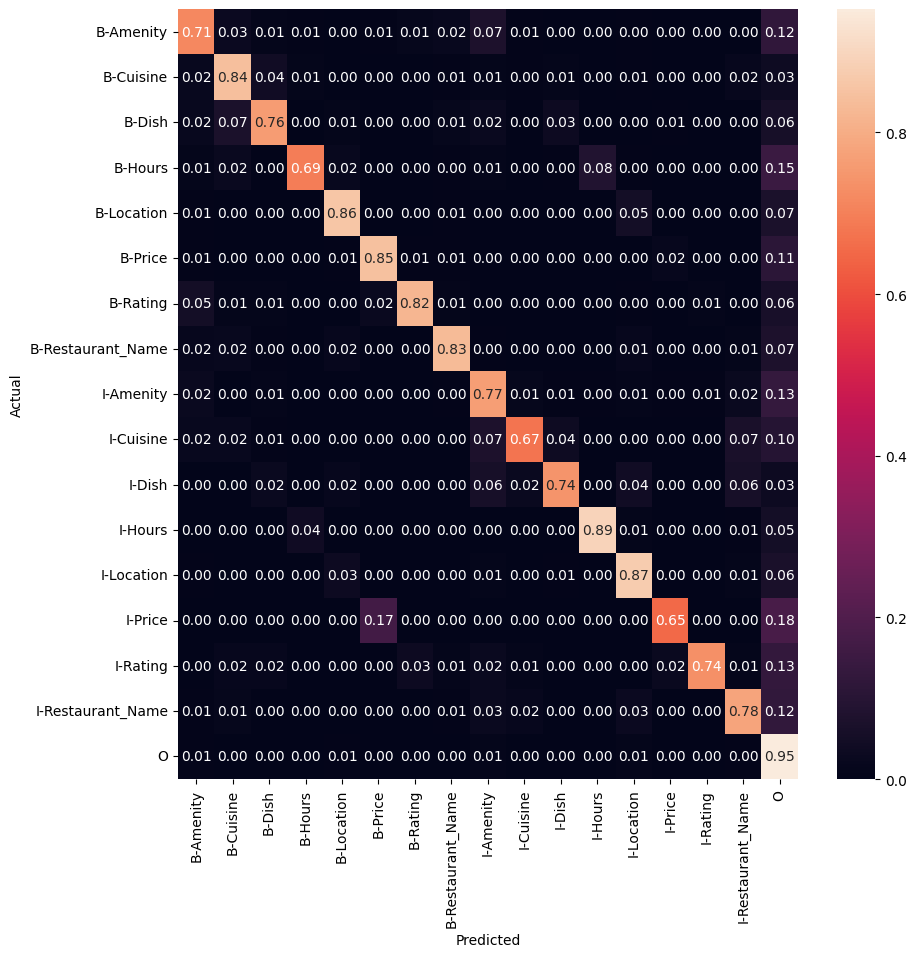

In [49]:
# PLot confusion matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = [tagger.tag(xseq) for xseq in X_test]
labels = list(set(chain(*y_test)))
labels.sort()

cm = confusion_matrix(list(chain(*y_test)), list(chain(*y_pred)), labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()